In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
fold_info = pd.read_csv('BreaKHis_v1/Folds.csv')
fold_info['label'] = fold_info['filename'].str.extract('(malignant|benign)')
fold_info.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb

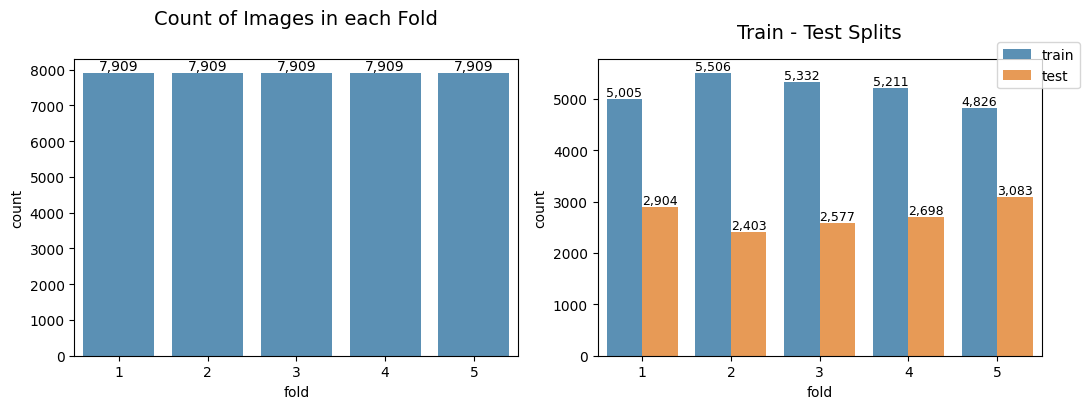

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)

sb.countplot(data=fold_info, x='fold', color='C0', ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, labels=[f'{x:,.0f}' for x in bars.datavalues])

ax1.set_title('Count of Images in each Fold', size=14, pad=25)

sb.countplot(data=fold_info, x='fold', hue='grp', palette='tab10', ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f'{x:,.0f}' for x in bars.datavalues], size=9)

ax2.set_title('Train - Test Splits', size=14, pad=15)
ax2.legend(loc=(0.9, 0.9))

##### Magnification factors
    Ashtaiwi, A. Optimal Histopathological Magnification Factors for Deep Learning-Based Breast Cancer Prediction. Appl. Syst. Innov. 2022, 5, 87. https://doi.org/10.3390/asi5050087

In [6]:
selected_fold = 2
selected_fold_data = fold_info.query('fold == @selected_fold').copy()

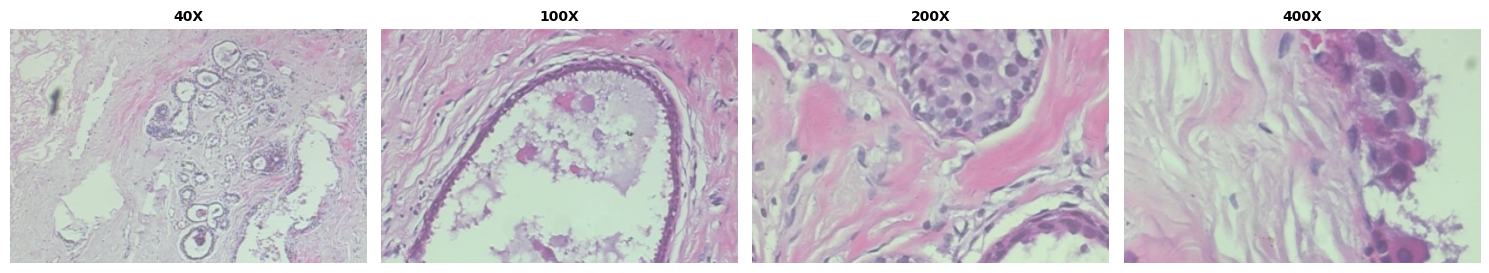

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6), dpi=100, tight_layout=True)
sample_images = fold_info.groupby('mag', as_index=False).first()

for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f'{row.mag}X', size=10, weight=600)
    ax.axis('off')

plt.show()

In [8]:
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")
train.shape, test.shape

((2682, 5), (1151, 5))

##### Target Distribution
    If the model predicts all positives, it indicates relatively good performance. However, this issue may arise due to data imbalance.

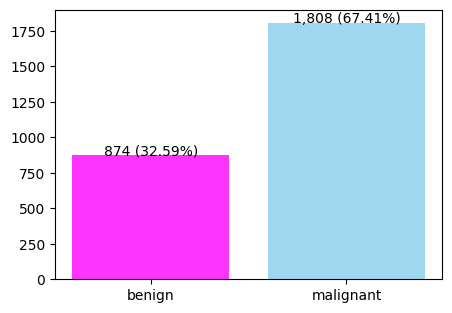

In [9]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train['label'].value_counts(ascending=True)

fig, ax = plt.subplots(figsize=(5, 3.5))
ax.bar(class_names, label_counts, color=['magenta', 'skyblue'], alpha=0.8)
ax.bar_label(ax.containers[0], padding=-2,
             labels=[f'{x:,} ({x/len(train):.2%})' for x in label_counts])

ax.set_xticks(class_names)
ax.set_xticklabels(class_names, rotation=0, ha='center')

plt.show()

##### Full positive (malignant) predictor

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score

In [11]:
y = train['label'].map(classes)
positive_only_preds = np.ones_like(y)

Visualize imbalance problems on a positive-predictor evaluation

In [12]:
from sklearn.metrics._plot.roc_curve import RocCurveDisplay
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

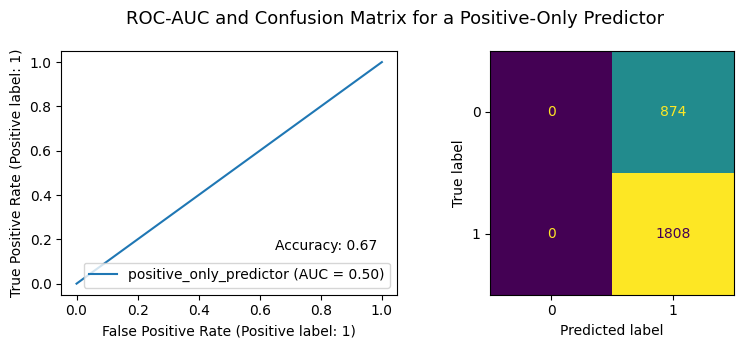

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)

RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1, name='positive_only_predictor')
ConfusionMatrixDisplay.from_predictions(y, positive_only_preds, ax=ax2, colorbar=False)

ax1.text(0.65, 0.15, f'Accuracy: {accuracy_score(y, positive_only_preds):.2f}')
fig.suptitle('ROC-AUC and Confusion Matrix for a Positive-Only Predictor', size=13)

plt.show()

##### Getting Data

In [14]:
from data_loader import get_data, load_image

2023-04-15 20:55:30.903413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 20:55:30.944827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 20:55:30.945900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 20:55:31.772440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
seed = 0
train_tensor, validation_tensor, test_tensor = get_data(selected_fold=1, seed=seed)

##### Preprocessing Data

Cache and prefetch data for faster training

In [16]:
import tensorflow as tf

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_tensor = train_tensor.cache().shuffle(961).prefetch(buffer_size=AUTOTUNE)
validation_tensor = validation_tensor.cache().prefetch(buffer_size=AUTOTUNE)
test_tensor = test_tensor.cache().prefetch(buffer_size=AUTOTUNE)

2023-04-15 20:55:32.928065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1825]
	 [[{{node Placeholder/_0}}]]
2023-04-15 20:55:32.928501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1825]
	 [[{{node Placeholder/_1}}]]


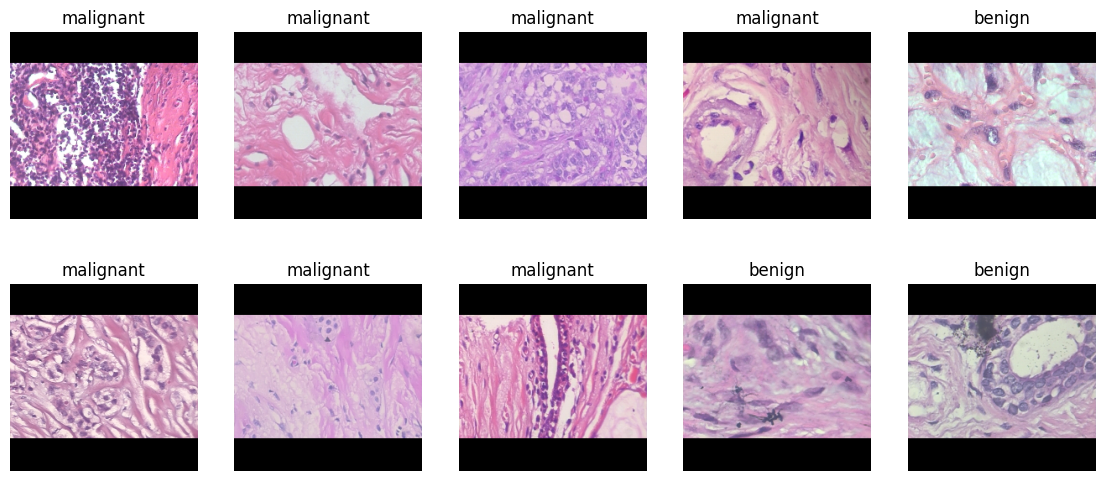

In [18]:
plt.figure(figsize=(14, 6))

for images, labels in train_tensor.take(2):
    labels = labels.numpy()
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
        plt.axis('off')

Data Augmentation

In [19]:
from tensorflow.keras import layers

In [20]:
def plot_augmentations_layers(image, augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    ax0.imshow(image.numpy().astype('uint8'))
    ax0.set_title('Original', size=14)
    ax0.axis('off')

    for _, ax in enumerate(axes):
        augmented_image = augmentation_layer(image)
        ax.imshow(augmented_image.numpy().astype('uint8'))
        ax.set_title(augment_name.title(), size=14, pad=10)
        ax.axis('off')

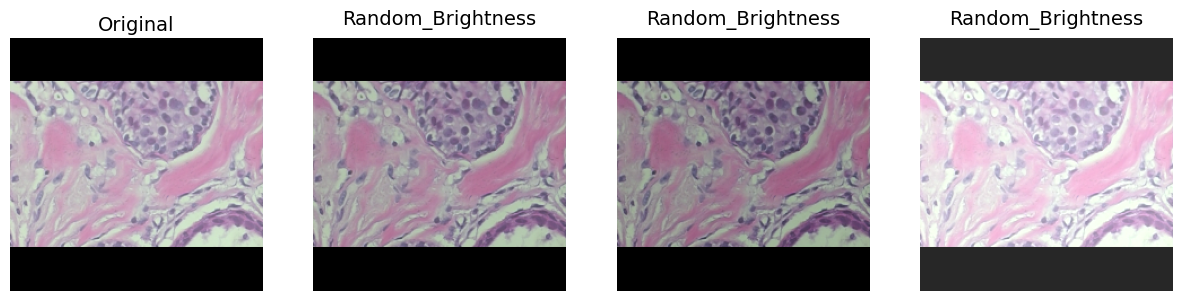

In [21]:
sample = load_image(*train[['filename', 'label']].iloc[0])[0]
plot_augmentations_layers(sample, layers.RandomBrightness(0.3, seed=seed))

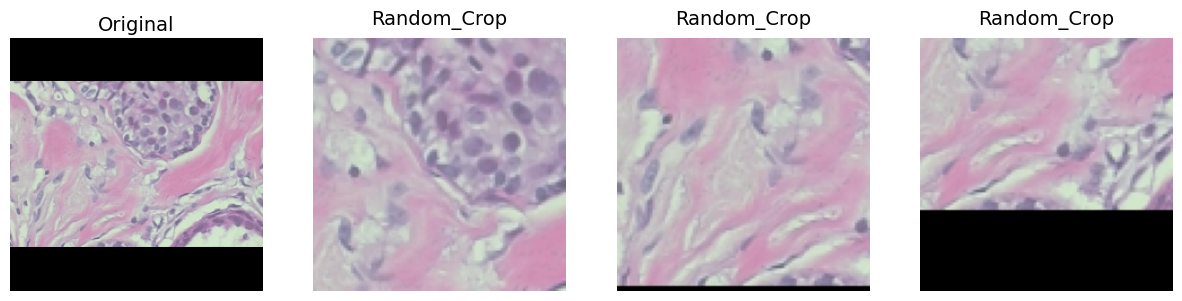

In [22]:
plot_augmentations_layers(sample, layers.RandomCrop(height=100, width=100, seed=seed))

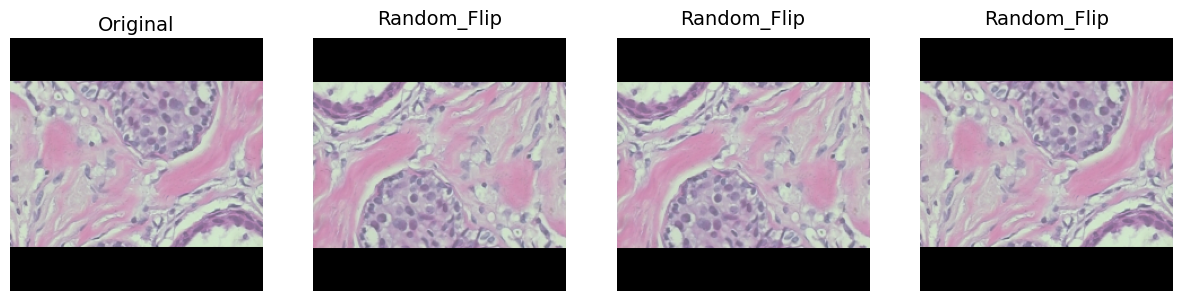

In [23]:
plot_augmentations_layers(sample, layers.RandomFlip())

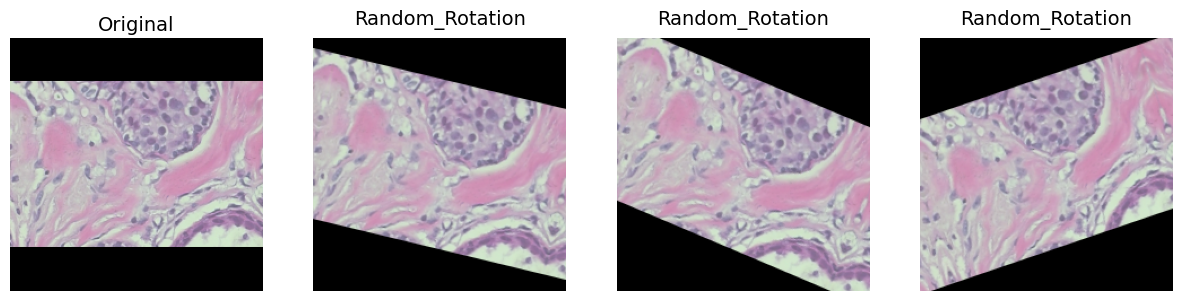

In [24]:
plot_augmentations_layers(sample, layers.RandomRotation(0.1, seed=seed))

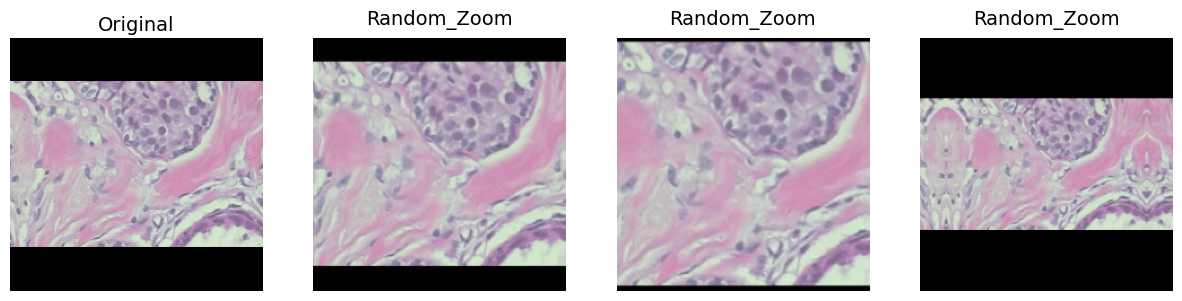

In [25]:
plot_augmentations_layers(sample, layers.RandomZoom(0.5, seed=seed))